# 4.2. Image Segmentation

In this notebook, we expand on the [geometrical shape classification project](quick_start.ipynb) we studied earlier. Previously, the network’s output was a **single label for the entire image**, indicating the category of the overall image.  

Here, we will extend this to predict a **label for each pixel** in the image, identifying the category each pixel belongs to. This type of problem is called **semantic segmentation**. Semantic segmentation is widely used in fields such as medical imaging (e.g., tumour detection) and autonomous driving (e.g., identifying roads, pedestrians, and vehicles).

To adapt the classification task to semantic segmentation, we need to make the following changes:  

1. **Dataset**:  
   - Instead of a single label per image, we now require **ground truth** for each pixel.  
   - The ground truth will consist of images where each pixel is assigned a category label.

2. **Network Architecture**:  
   - The network must output a **matrix** with the same spatial resolution as the input image (height × width).  
   - Each pixel in the output matrix corresponds to a predicted category for the corresponding input pixel.

## 0. Preparation

Before we dive into the project, let's start by preparing the necessary materials.

### Required Packages

Let's start with all the necessary packages to implement this tutorial.

- **[numpy](https://numpy.org/):** The main library for scientific computing in Python, commonly imported as `np`.
- **[matplotlib](https://matplotlib.org/):** Useful for plotting graphs and visualising data.
- **[torch](https://pytorch.org/docs/stable/index.html):** The core library in PyTorch for deep learning, helping us define and manage neural networks.
- **[torchvision](https://pytorch.org/vision/stable/index.html):** Contains tools and datasets for computer vision tasks.
- **[cv2](https://docs.opencv.org/4.x/index.html) (OpenCV):** A widely-used library for image processing.

Let's import these libraries now:

In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random

import torch
import torch.nn as nn
import torchvision

import cv2

Deep learning tasks can be computationally demanding. GPUs are often used because they are designed to handle complex calculations efficiently. In this case, if a **GPU** is available, PyTorch will use it; otherwise, it will default to using the **CPU**.

In [2]:
# Automatically selects GPU if available, else defaults to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Dataset 

In this section, we prepare our dataset for semantic segmentation. Instead of using pre-existing data, we will **generate our dataset on the fly**. This is useful for teaching purposes and allows us to focus on specific features of the task. 

Our dataset consists of images containing simple geometrical shapes:  
- **Circle**  
- **Ellipse**  
- **Rectangle**  

Each image is paired with a **segmentation mask**, where every pixel is labelled as:  
- **0 (background)**  
- **1 (circle)**  
- **2 (ellipse)**  
- **3 (rectangle)**  

We will also assign colours to these labels for visualisation purposes:

In [3]:
# Mapping of labels to shape names
label_to_shape = {
    0: 'background',
    1: 'circle',
    2: 'ellipse',
    3: 'rectangle'
}

# Colours for visualisation (RGB values)
label_colours = {
    'background': [0, 0, 0],      # Black
    'circle': [255, 0, 0],       # Red
    'ellipse': [0, 255, 0],      # Green
    'rectangle': [0, 0, 255]     # Blue
}

### Dataset Utility Functions  

We use utility functions to generate random backgrounds, draw shapes, and create segmentation masks.  

#### Creating Backgrounds

The `create_random_background` function generates backgrounds for the images. Backgrounds can either be:  
- **Noisy** (random pixel values) or  
- **Uniform** (a single random colour).  

In [4]:
def create_random_background(img_size, p=0.5):
    """
    Creates a background for an image. 
    
    Args:
        img_size (int): Size of the background (image will be square).
        p (float): Probability of generating a random noise background.
        
    Returns:
        numpy array: Background image of size (img_size, img_size, 3).
    """
    # If a randomly generated number is above p, create a noise background; otherwise, use a uniform colour
    if np.random.rand() > p:
        # Random noise background: random pixel values for each RGB channel
        return np.random.randint(0, 256, (img_size, img_size, 3), dtype='uint8')
    else:
        # Uniform background: same colour for each pixel
        return np.zeros((img_size, img_size, 3), dtype='uint8') + np.random.randint(0, 256, dtype='uint8')

#### Drawing Foreground Shapes

The `create_random_shape` function draws a random geometrical shape (circle, ellipse, or rectangle) on top of a background. It also creates the corresponding **ground truth mask**, where:  
- The background is labelled as **0**, and  
- Each shape is assigned a unique label (1 for circle, 2 for ellipse, 3 for rectangle).  

In [5]:
def create_random_shape(background_img, is_filled):
    """
    Draws a random geometrical shape on an image and creates a corresponding ground truth mask.
    
    Args:
        background_img (numpy.ndarray): The background image.
        is_filled (bool): Whether the shapes should be filled or outlined.
    
    Returns:
        tuple: (image with shapes, ground truth mask)
    """
    # Generate a random colour for the shape
    shape_colour = [np.random.randint(0, 256) for _ in range(3)]
    
    # Generate ground truth mask (single-channel image)
    ground_truth = np.zeros(background_img.shape[:2], dtype=np.uint8)
    
    # Randomly choose a shape type (1: Circle, 2: Ellipse, 3: Rectangle)
    shape_type = np.random.randint(1, len(label_to_shape))
    
    # Randomly position and size the shape
    centre = np.random.randint(background_img.shape[0] // 4, 3 * (background_img.shape[0] // 4), 2)
    
    if shape_type == 1:  # Circle
        radius = np.random.randint(10, background_img.shape[0] // 4)
        background_img = cv2.circle(background_img, centre, radius, shape_colour, thickness=-1 if is_filled else 2)
        ground_truth = cv2.circle(ground_truth, centre, radius, shape_type, thickness=-1)
    
    elif shape_type == 2:  # Ellipse
        axes = [np.random.randint(5, 10), np.random.randint(10, 20)]
        angle = np.random.randint(0, 360)
        background_img = cv2.ellipse(background_img, centre, axes, angle, 0, 360, shape_colour, thickness=-1 if is_filled else 2)
        ground_truth = cv2.ellipse(ground_truth, centre, axes, angle, 0, 360, shape_type, thickness=-1)
    
    elif shape_type == 3:  # Rectangle
        corner = np.random.randint(0, background_img.shape[0], 2)
        background_img = cv2.rectangle(background_img, centre, corner, shape_colour, thickness=-1 if is_filled else 2)
        ground_truth = cv2.rectangle(ground_truth, centre, corner, shape_type, thickness=-1)
    
    return background_img, ground_truth

#### Creating Tiled Images

The `tile_image` function divides the image into tiles and adds a shape to each tile. This ensures multiple shapes appear in one image. 

In [6]:
def tile_image(background_img, is_filled):
    """
    Divides the background image into tiles and draws a shape in each tile.
    
    Args:
        background_img (numpy.ndarray): Background image.
        is_filled (bool): Whether shapes are filled or outlined.
    
    Returns:
        tuple: (image with tiled shapes, ground truth mask)
    """
    height, width, _ = background_img.shape
    ground_truth = np.zeros((height, width), dtype=np.uint8)
    
    num_tiles = 2  # Number of tiles along each dimension
    tile_height = height // num_tiles
    tile_width = width // num_tiles
    
    for i in range(0, height, tile_height):
        for j in range(0, width, tile_width):
            tile = background_img[i:i + tile_height, j:j + tile_width]
            tile_with_shape, tile_mask = create_random_shape(tile, is_filled)
            background_img[i:i + tile_height, j:j + tile_width] = tile_with_shape
            ground_truth[i:i + tile_height, j:j + tile_width] = tile_mask
    
    return background_img, ground_truth

#### Visualising the Dataset

To make it easier to interpret the segmentation results, we can visualise all pixels belonging to the same category with the same colour. For instance, all rectangles will appear in blue, regardless of their surface colour. This standardised colouring helps to clearly distinguish between different object categories and makes it easier to evaluate the model's performance visually.

To achieve this, we implement the `label_to_colour` function. This function iterates through all the labels in the image and assigns each one a predefined colour from a colour map.

In [29]:
def label_to_colour(mask):
    """
    Converts a label mask to a coloured image for visualisation.
    
    Args:
        mask (numpy.ndarray): Ground truth mask.
    
    Returns:
        numpy.ndarray: Coloured representation of the mask.
    """
    coloured_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label in np.unique(mask):
        coloured_mask[mask == label] = label_colours[label_to_shape[label]]
    return coloured_mask

To better understand the generated data, we visualise pairs of:  
- **Input images** with random backgrounds and shapes that may have random colours for shapes and backgrounds.  
- **Ground truth masks** use fixed colours for visualisation (e.g., blue for rectangles) but are stored as label numbers internally (0 for background, 1–3 for shapes). 

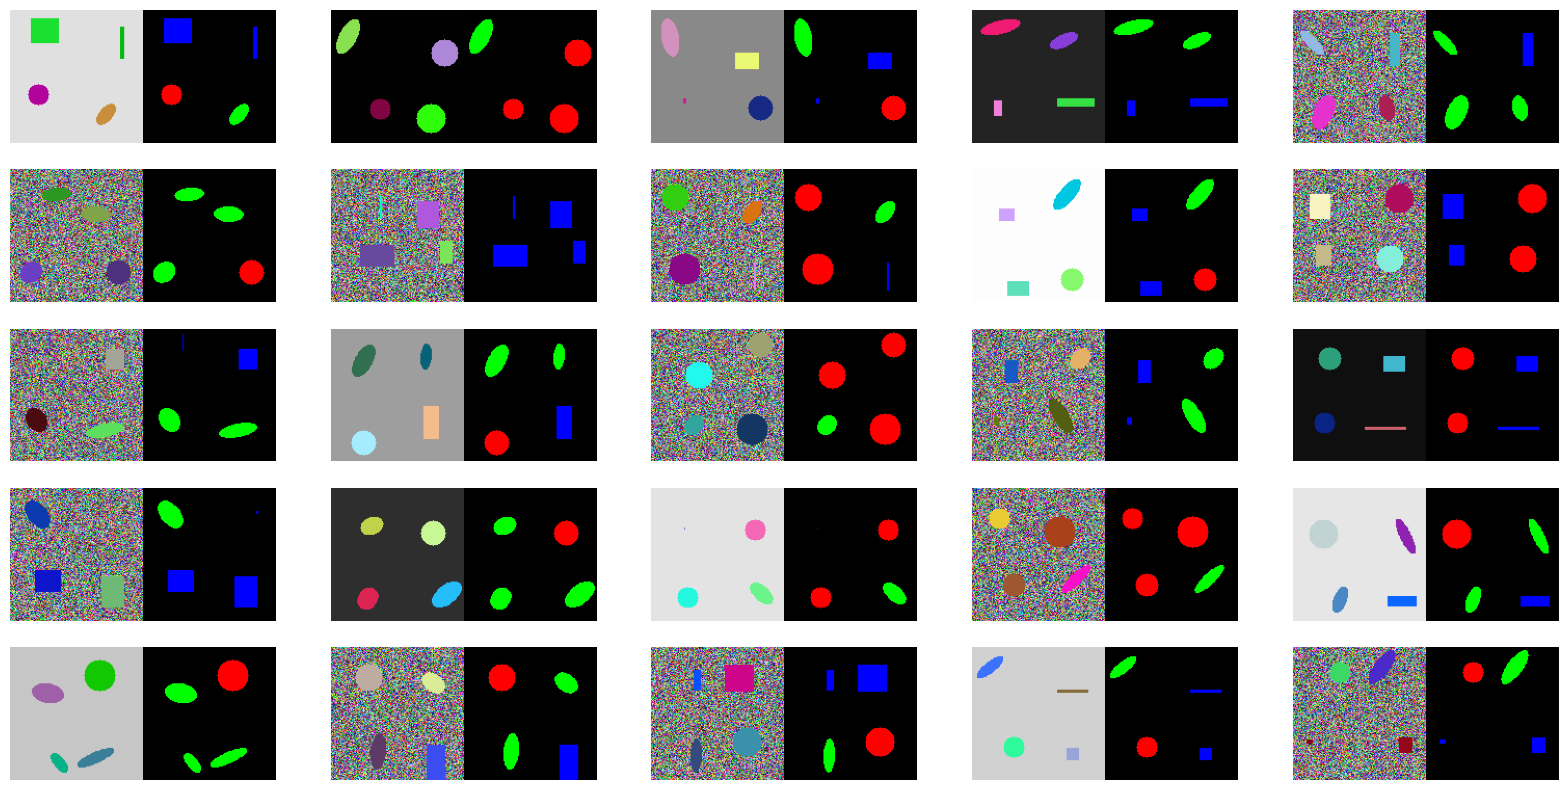

In [8]:
# Generate and display 25 random examples
img_size = 128
is_filled = True
probability_noise = 0.5

fig, ax = plt.subplots(5, 5, figsize=(20, 10))
for i in range(25):
    img, mask = tile_image(create_random_background(img_size, probability_noise), is_filled)
    ax[i // 5, i % 5].imshow(np.concatenate([img, label_to_colour(mask)], axis=1))
    ax[i // 5, i % 5].axis('off')
plt.show()

### PyTorch Data Pipeline

Now that we have created our dataset, we need to create **PyTorch dataloaders** to efficiently manage and load our data during model training and evaluation. PyTorch dataloaders make it easier to handle large datasets by loading small batches of data sequentially, which is essential for efficient memory usage and faster processing.


In PyTorch, the dataset class defines how to access and process individual data samples. To create a custom dataset, we inherit from `torch.utils.data.Dataset` and implement two mandatory methods:

1. **`__len__`:** Returns the total number of samples in the dataset.
2. **`__getitem__`:** Returns a single sample (input image and corresponding label) when given an index.

We have implemented the `ShapeDataset` class, which is responsible for generating data samples dynamically. This class uses the `tile_img` function within its `__getitem__` method to create a random sample whenever it is accessed.

In [19]:
# Custom PyTorch Dataset for Shape Images
class ShapeDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, img_size, bg_type_probability, transform=None):
        """
        Initialise the dataset with the necessary parameters.

        Args:
            num_samples (int): Number of samples in the dataset.
            img_size (int): Size of the images (assumes square images).
            bg_type_probability (float): Probability of a uniform vs noisy background.
            transform (callable, optional): Transformations to apply to input images.
        """
        self.num_samples = num_samples
        self.img_size = img_size
        self.bg_type_probability = bg_type_probability
        self.transform = transform

    def __len__(self):
        """Return the total number of samples."""
        return self.num_samples

    def __getitem__(self, index):
        """
        Generate a single data sample.

        Args:
            index (int): Sample index (not used here since samples are generated randomly).

        Returns:
            tuple: (input_image, ground_truth) where
                   input_image is a tensor of shape [C, H, W],
                   ground_truth is a tensor of shape [H, W].
        """
        # Generate a random image and its ground truth
        image, ground_truth = tile_image(
            create_random_background(self.img_size, self.bg_type_probability), is_filled=True
        )

        # Apply transformations to the input image
        if self.transform:
            image = self.transform(image)

        # Convert the ground truth to a PyTorch tensor (with long dtype for loss computation)
        ground_truth = torch.tensor(ground_truth, dtype=torch.long)
        return image, ground_truth

#### Data Augmentation

In our `ShapeDataset`, the `transform` function is applied **only to the input images**. This is because the transformations we are using—normalisation and conversion to `torch.Tensor`—are relevant solely to the input data. The ground truth (labels) is converted to a PyTorch tensor separately without any additional transformations.

If we were to include image augmentations (e.g., cropping or random cropping) as part of the `transform` pipeline, **we would need to apply the exact same augmentations to the ground truth**. This ensures that the ground truth aligns with the modified input data. For example:

- If an image is randomly cropped, the corresponding label (e.g., segmentation mask) must also be cropped in the same way.
- If an image is flipped horizontally, the label must also be flipped to maintain consistency.

Failure to do this would lead to a **mismatch** between the input data and its corresponding labels, causing errors during training.


In most deep learning projects, data augmentation is a crucial step to prevent overfitting. Overfitting occurs when a model memorises the training set instead of learning generalisable patterns. Since neural networks often have millions of parameters, they can overfit when the training dataset is small or lacks diversity.

Random data augmentation introduces variability to the training samples, improving generalisation by:
- Simulating a broader range of input scenarios.
- Forcing the network to learn robust features instead of relying on specific patterns in the dataset.

In this example, we generate the data samples programmatically, and each sample is already randomised. As a result, our dataset inherently contains sufficient variability, eliminating the need for additional augmentations.

#### Data Transformations

In this example, we use two standard transformations:

1. **`ToTensor`**: Converts an image into a PyTorch tensor. PyTorch models work with tensors, so we must apply this transformation before feeding data into our model.
  
2. **`Normalize`**: Scales image pixel values so they are centred around zero. This is important because many deep learning models perform better when the data has a mean of zero and a standard deviation close to one. We specify the `mean` and `std` values for normalisation, tailored to our dataset.

Transformations are applied sequentially using `torchvision.transforms.Compose`, which allows chaining multiple transformations together.

In [10]:
# Set mean and standard deviation for normalisation
mean = 0.5
std = 0.25

# Compose transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),               # Convert to tensor
    torchvision.transforms.Normalize(mean, std),     # Normalise with mean and std
])

#### DataLoader: Managing Data Batches

`DataLoader` in PyTorch enables efficient batch processing, which is crucial for training and evaluation. Here are some important parameters for `DataLoader`:

- **`batch_size`**: Defines how many samples are processed in each batch. Processing in batches allows efficient use of GPU resources and is necessary for stochastic gradient descent (SGD).
  
- **`num_workers`**: Specifies the number of CPU threads to load and preprocess the data before sending it to the GPU. Using multiple workers can speed up data loading, especially with larger datasets.
  
- **`shuffle`**: Randomly shuffles the data at each epoch. This is usually set to `True` during training to prevent the model from learning the order of the data.

> **Note**: `batch_size` and `shuffle` settings can vary between training and testing. For example, we may set a larger `batch_size` and avoid shuffling during testing since we do not need to update model weights.

In [11]:
bg_type_probability = 1  # don't put noise in the background

num_train_samples = 1000

# Instantiate dataset for training
train_dataset = ShapeDataset(num_train_samples, img_size, bg_type_probability, transform=transform)

# Set batch size
batch_size = 8

# Create DataLoader for training
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, sampler=None
)

num_test_samples = 1000

# Instantiate dataset for validation
val_dataset = ShapeDataset(num_test_samples, img_size, bg_type_probability, transform=transform)

# Create DataLoader for validation
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, sampler=None
)

## 2. Model

With our images generated and PyTorch dataloaders ready, we can now move on to building our neural network model.

Since our task is relatively straightforward, we don’t need a highly complex model. In this example, we define a simple convolutional neural network (CNN) that will perform well on basic image classification tasks. Our model will inherit from `torch.nn.Module`, a base class in PyTorch used for creating neural network models. Any model that inherits from this class must implement at least a `forward` function, which defines how data will pass through the network layers.

### Architecture

Let’s revisit the architecture we used for image classification to understand the changes needed for semantic segmentation. 

#### Image Classification
For image classification, our network included:
1. **Feature Extraction**  
   Gradually reduced the spatial resolution of the input while generating abstract feature sets to represent high-level concepts like shapes or textures.
   
2. **Global Average Pooling**  
   Collapsed the spatial dimensions (height and width) by averaging across all locations. This produced a compact representation of the features, summarising the entire image.

3. **Classifier**  
   A fully connected (linear) layer that mapped the summarised features to the number of classes, producing a single prediction for the entire image.

In this setup, the final output was not spatially structured, as the goal was to predict a single label for the entire input image.


#### Semantic Segmentation
For semantic segmentation, our objective changes: **we need to predict a label for each pixel in the input image.** This means the architecture must:
1. Extract meaningful features, as before.
2. **Upsample the spatial resolution** of the extracted features to match the input image's resolution.
3. Classify each pixel based on these upsampled features.


**Key Modifications:**
1. **Upsampling the Features**  
   Instead of global average pooling, we restore the spatial resolution using one or both of the following techniques:  
   - **`torch.nn.functional.interpolate`**  
     This function performs interpolation to resize feature maps to the desired resolution. It is efficient and simple but does not involve any learnable parameters.
   - **`torch.nn.ConvTranspose2d`**  
     Also known as transposed convolution, this operation upsamples feature maps using learnable weights, similar to standard convolutions but in reverse. It often produces sharper results compared to interpolation.

   In this example, we use a combination of both:
   - Two **`ConvTranspose2d`** layers gradually upsample the features.
   - A final **`interpolate`** step ensures the output matches the exact resolution of the input image.

2. **Pixel-Wise Classifier**  
   Instead of a fully connected (linear) layer, we use a **convolutional layer (`Conv2d`)** with a kernel size of \( 1 \times 1 \). This allows the model to assign a class label to each pixel in the upsampled feature map.

Recall from the image classification problem, our architecture contained three main components:
1. **Feature Extraction**: Gradualyl reducing special resolution and create more abstract feature sets.
2. **Global Average Pooling**: This layer pools the features across the entire spatial resolution, producing a summary of each feature map.
3. **Classifier**: A linear layer maping the extracted features to the number of classes, providing the final predictions.

This type of architecture, where all operations involve convolutional layers (including transposed convolutions), is known as a **Fully Convolutional Network (FCN)**. It was introduced in the seminal paper "[Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1411.4038)". FCNs form the foundation of modern semantic segmentation models.

In [12]:
# Define the Simple CNN Model
class SimpleNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()

        # Feature extraction block (encoder)
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # in=3, out=16
            nn.BatchNorm2d(16), # it must be the same as out of prvious layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # in=16 (it must be the same as out of previous layer)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Upsampling block (decoder)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2), # 64 comes from the output of the self.features
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        # Classifier layer
        self.classifier = nn.Conv2d(16, num_classes, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Store the input size for final upsampling
        size = x.shape[-2:]
        # x shape is <B, 3, 128, 128>
        
        x = self.features(x)
        # x shape is <B, 64, 15, 15>
        
        x = self.decoder(x)
        # x shape is <B, 16, 63, 63>
        
        x = torch.nn.functional.interpolate(x, size=size, mode="bilinear", align_corners=False)
        # x shape is <B, 16, 128, 128>
        
        x = self.classifier(x)
        # x shape is <1, 16, 128, 128>
        return x

### Network

Next we make an instance of our previously defined architecture.
We move the model to GPU and print the model.

In [13]:
# Define the number of classes in the dataset (e.g., 4: background, circle, ellipse, rectangle)
num_classes = len(label_to_shape)

# Create an instance of the SimpleNet model
model = SimpleNet(num_classes=num_classes)

# Move the model to the GPU (if available)
model = model.to(device)

# Print the model architecture for reference
print(model)

SimpleNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, m

## 3. Training and Testing Routines

Now that we’ve prepared our dataset and built our model, it’s time to start training and evaluating our neural network. This section explains each component of the training process, including optimisation, loss calculation, and accuracy evaluation.

#### Optimiser

The optimiser is responsible for updating the model's parameters to minimise the loss during training. When defining an optimiser, we choose which parameters to optimise, the optimisation algorithm, and a key parameter called the **learning rate**. The learning rate controls how much to adjust the model's parameters with each step.

In our case, we use **Stochastic Gradient Descent (SGD)** with parameters for `momentum`, `learning_rate`, and `weight_decay`.

In [14]:
# Define optimiser and criterion
params_to_optimise = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.01
weight_decay = 1e-4

# Initialising the SGD optimiser with specified parameters
optimiser = torch.optim.SGD(
    params=params_to_optimise,
    lr=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay
)

### Loss Function

The **loss function** quantifies how well the model’s predictions match the ground truth. In this example, we use **categorical cross-entropy** (`nn.CrossEntropyLoss`) as our loss function, which is well-suited for classification tasks where the goal is to correctly categorise inputs into discrete classes (like recognising different shapes).

We can consider the learning paradigm in this example to be **semi-supervised**. The ground-truth labels for our shapes were not manually annotated by humans. Instead, we automatically generated these labels using mathematical equations to define the geometrical shapes. This approach allowed us to skip the laborious process of manually labelling each image, providing labelled data in a more efficient way.

In [15]:
# Initialise the loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss().to(device)

### Training utility functions

For training semantic segmentation models, it is often helpful to define utility functions for monitoring performance and handling specific training nuances. Here, we define an **accuracy** function to evaluate how well the model's predictions align with the ground truth.

In many scenarios, including ours, the background pixels can dominate the accuracy metric because they usually outnumber foreground pixels. Ignoring background pixels during accuracy computation allows us to focus on the model's ability to segment the foreground objects. Here’s why this approach can be beneficial:  
1. **Foreground Focus**: We are primarily interested in whether the network can successfully segment objects in the foreground.  
2. **Accuracy Balance**: Background pixels can artificially inflate the overall accuracy, masking poor performance on foreground objects.  

**Notes:**
1. **Accuracy**: The function ignores background pixels (labelled as `ignore_label`, default is 0) when reporting accuracy. This ensures the metric reflects the segmentation performance for foreground objects.  
2. **Loss Function**: The loss function still considers background pixels. This is often done to ensure that the model learns the distinction between background and foreground. However, if needed, we can modify the loss to ignore or down-weight background pixels.

**Potential Enhancements:**
- **Ignore Background in Loss**: You could modify the loss function to exclude background pixels entirely.  
- **Weighting Pixels**: Assign different weights to pixels based on their type (e.g., foreground pixels might be given a higher weight)

In [16]:
def accuracy(output, target, ignore_label=0):
    """
    Computes pixel-wise accuracy, optionally ignoring specified labels.
    
    Args:
        output (torch.Tensor): Model predictions with shape <B, C, H, W>.
        target (torch.Tensor): Ground truth labels with shape <B, H, W>.
        ignore_label (int): Label to ignore in accuracy computation (default=0).

    Returns:
        torch.Tensor: Mean accuracy across all valid pixels.
    """
    # Ensure computations are performed without gradients for efficiency
    with torch.no_grad():
        # Convert predictions to class indices (highest probability for each pixel)
        predicted_classes = torch.argmax(output, dim=1)  # Shape: <B, H, W>
        
        # Compare predictions to ground truth labels
        correct_predictions = predicted_classes.eq(target)  # Shape: <B, H, W>
        
        # Exclude pixels with the ignored label
        valid_pixels = target != ignore_label  # Mask to filter out ignored pixels
        
        # Calculate the accuracy over valid pixels
        valid_correct_predictions = correct_predictions[valid_pixels]
        accuracy = valid_correct_predictions.float().mean()  # Compute mean accuracy
        
        return accuracy

To train and evaluate our model, we define a utility function called `epoch_loop`, which performs the operations required in each epoch. An **epoch** refers to one complete pass through the entire dataset—essentially, processing all samples in the dataset once.

Since much of the code for training and testing is similar, it’s efficient to combine both procedures into a single function. The parts that differ for training and testing can be separated within the function using conditional statements. For example, during training, we need to perform additional steps to update the model’s parameters:

1. **Compute the Gradient**: We reset the gradients with `optimizer.zero_grad()`, ensuring that previous gradients do not interfere with the current update.
2. **Backpropagate the Loss**: We calculate the gradients with `loss.backward()`, which backpropagates the loss to update each parameter in the network.
3. **Optimise the Weights**: Finally, `optimizer.step()` adjusts the weights based on the computed gradients, helping the model learn from the errors.

<font color='red'>**Important**</font>: When evaluating (or testing) a model, it’s essential to call the `.eval()` method. This prevents certain layers (like dropout or batch normalisation) from updating, ensuring a consistent evaluation.

<font color='red'>**Important**</font>: Also, use `torch.set_grad_enabled()` to specify whether gradients should be calculated (`True` during training and `False` during testing).

In [24]:
def epoch_loop(model, db_loader, criterion, optimiser=None):
    """
    Run a single epoch for training or testing.
    
    Args:
        model (torch.nn.Module): The model to train/test.
        db_loader (DataLoader): Data loader for training or testing data.
        criterion (Loss Function): Loss function for computing the error.
        optimiser (torch.optim.Optimizer): Optimiser for training; if None, evaluation mode is assumed.
        
    Returns:
        accuracies (list): List of accuracies for each batch.
        losses (list): List of losses for each batch.
    """
    # Determine whether in training mode
    is_train = optimiser is not None
    model.train() if is_train else model.eval()
    
    accuracies = []
    losses = []
    
    # Disable gradient computation for evaluation
    with torch.set_grad_enabled(is_train):
        for batch_ind, (img, target) in enumerate(db_loader):
            # Move images and targets to device (GPU or CPU)
            img = img.to(device)
            target = target.to(device)
            
            # Forward pass: compute output and loss
            output = model(img)
            loss = criterion(output, target)
            losses.extend([loss.item() for _ in range(img.size(0))])

            # Compute accuracy
            acc = accuracy(output, target).cpu().numpy()
            accuracies.extend([acc for _ in range(img.size(0))])
            
            # Backward pass and optimisation step for training
            if is_train:
                optimiser.zero_grad()   # Reset gradients
                loss.backward()         # Backpropagate loss
                optimiser.step()        # Update parameters
    
    return accuracies, losses

## 4. Experiments with Uniform Background

In this section, we will evaluate the performance of our semantic segmentation model when the background pixels are uniform and free of noise. This controlled scenario helps us understand how well the model performs when there is no added complexity in distinguishing the foreground objects from the background.

### Actual Learning

With all components set up (data, model, loss, and optimiser), we can start the training and testing loop. In this example, we train the model for 10 epochs, meaning the model will go through all data points 10 times.

In [25]:
# Dataset
bg_type_probability = 1  # don't put noise in the background

num_train_samples = 1000

# Instantiate dataset for training
train_dataset = ShapeDataset(num_train_samples, img_size, bg_type_probability, transform=transform)

# Set batch size
batch_size = 8

# Create DataLoader for training
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, sampler=None
)

num_test_samples = 1000

# Instantiate dataset for validation
val_dataset = ShapeDataset(num_test_samples, img_size, bg_type_probability, transform=transform)

# Create DataLoader for validation
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, sampler=None
)


# Model
model = SimpleNet(len(label_to_shape)).to(device)
params_to_optimize = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.1
weight_decay = 1e-4
optimiser = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

# Set the number of epochs for training
epochs = 10
initial_epoch = 0

# Logs for tracking accuracy and loss over time
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}

for epoch in range(initial_epoch, epochs):
    # Run a training epoch
    train_log = epoch_loop(model, train_loader, criterion, optimiser)
    
    # Run a validation epoch (no optimiser, so the model is in evaluation mode)
    val_log = epoch_loop(model, val_loader, criterion, optimiser=None)
    
    # Print training and validation results for this epoch
    print('[Epoch %02d] Train loss=%.4f, acc=%.2f  |  Test loss=%.4f, acc=%.2f' % 
          (
              epoch, 
              np.mean(train_log[1]), np.mean(train_log[0]),
              np.mean(val_log[1]), np.mean(val_log[0])
          ))
    
    # Log the results for plotting later
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[Epoch 00] Train loss=0.2670, acc=0.12  |  Test loss=0.2679, acc=0.29
[Epoch 01] Train loss=0.1516, acc=0.36  |  Test loss=0.1560, acc=0.41
[Epoch 02] Train loss=0.1424, acc=0.37  |  Test loss=0.1365, acc=0.38
[Epoch 03] Train loss=0.1330, acc=0.40  |  Test loss=0.1307, acc=0.38
[Epoch 04] Train loss=0.1254, acc=0.42  |  Test loss=0.1201, acc=0.44
[Epoch 05] Train loss=0.0989, acc=0.58  |  Test loss=0.0837, acc=0.65
[Epoch 06] Train loss=0.0749, acc=0.69  |  Test loss=0.0656, acc=0.76
[Epoch 07] Train loss=0.0642, acc=0.77  |  Test loss=0.0612, acc=0.80
[Epoch 08] Train loss=0.0531, acc=0.83  |  Test loss=0.0523, acc=0.81
[Epoch 09] Train loss=0.0465, acc=0.86  |  Test loss=0.0481, acc=0.85


### Reporting Results

Finally, we’ll plot the accuracy and loss over the training epochs to evaluate the model’s performance. These plots can reveal if the model is improving over time or if adjustments are needed to hyperparameters.

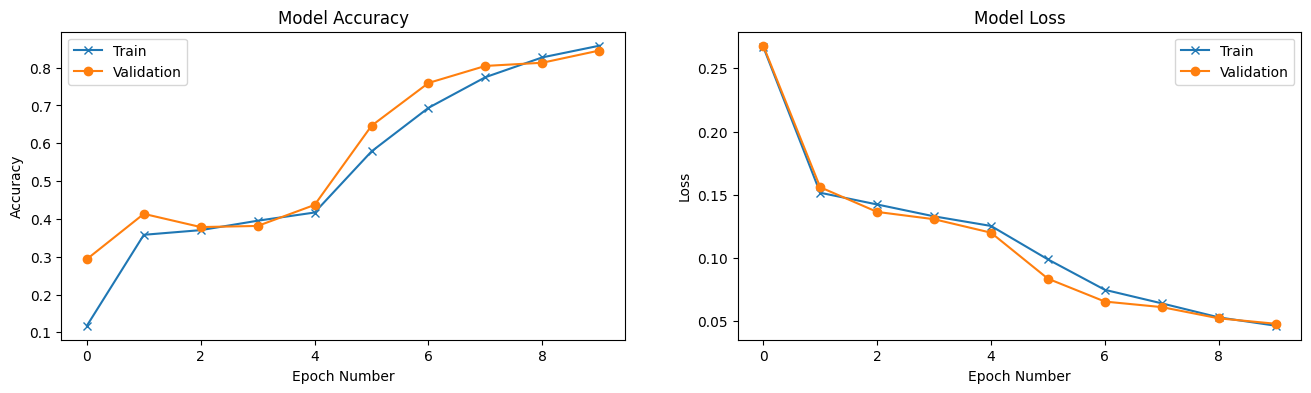

In [26]:
# Plot accuracy and loss over epochs
fig = plt.figure(figsize=(16, 4))

# Plot accuracy
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_logs['acc'], '-x', label='Train')
ax.plot(val_logs['acc'], '-o', label='Validation')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Accuracy')
ax.legend()

# Plot loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(train_logs['loss'], '-x', label='Train')
ax.plot(val_logs['loss'], '-o', label='Validation')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

### Visualising the Model's Output

To better understand how the model interprets the data, we visualise its output for a single sample. This comparison includes:  
1. **Input Image**: The original image provided to the model.  
2. **Ground Truth**: The correct segmentation labels for the input image.  
3. **Model Output**: The segmentation predictions generated by the model.

In [44]:
def visualise_batch_output(data_loader, max_imgs=4):
    # Iterate over the training data loader
    for batch_index, (images, ground_truth) in enumerate(data_loader):
        # Move the input images and ground truth labels to the device (e.g., GPU or CPU)
        images = images.to(device)
        ground_truth = ground_truth.to(device)
        
        # Forward pass: get model predictions for the batch of images
        predictions = model(images)
        break  # Exit after processing one batch for visualisation
    
    # Create a figure to display the input image, ground truth, and model output
    fig = plt.figure(figsize=(22, 8))

    ax_ind = 0
    for i in range(min(max_imgs, len(predictions))):
        # Display the input image
        ax_ind += 1
        ax = fig.add_subplot(2, max_imgs * 3 // 2, ax_ind)
        ax.axis('off')  # Remove axes for better visualisation
        # Transform image tensor back to RGB format and de-normalise it for visualisation
        ax.imshow(images[i].detach().cpu().numpy().transpose(1, 2, 0) * std + mean)
        ax.set_title('Input Image')
        
        # Display the ground truth labels as coloured segmentation
        ax_ind += 1
        ax = fig.add_subplot(2, max_imgs * 3 // 2, ax_ind)
        ax.axis('off')
        # Convert the ground truth labels to a colour map for better visualisation
        ax.imshow(label_to_colour(ground_truth[i].detach().cpu().numpy()))
        ax.set_title('Ground Truth')
        
        # Display the model's predicted segmentation
        ax_ind += 1
        ax = fig.add_subplot(2, max_imgs * 3 // 2, ax_ind)
        ax.axis('off')
        # Convert the predicted labels (argmax over channels) to a colour map
        ax.imshow(label_to_colour(torch.argmax(predictions[i], dim=0).detach().cpu().numpy()))
        ax.set_title('Model Output')
    
    # Show the plots
    plt.show()

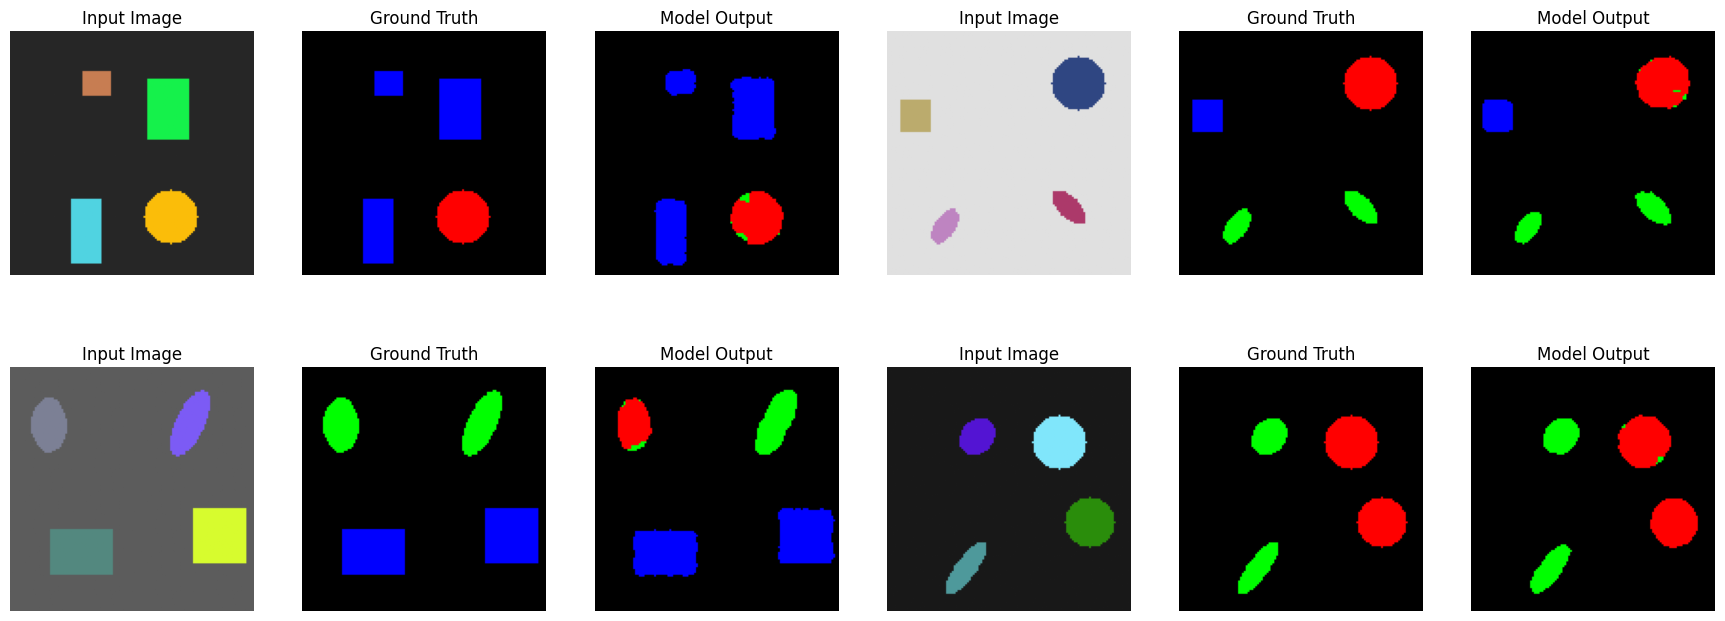

In [45]:
visualise_batch_output(val_loader)

## 5. Experiment With Noise

From the results above, we can obseer that quantitativeley and qualitativeley we obtain decent segmentation resutls for our tox example in relativeley a few numebr fo epochs.

Let's experiment with a more complex dataset with noisy backgrounds.

In [50]:
# Dataset
bg_type_probability = 0.5  # add noise half of the time

num_train_samples = 1000

# Instantiate dataset for training
train_dataset = ShapeDataset(num_train_samples, img_size, bg_type_probability, transform=transform)

# Set batch size
batch_size = 8

# Create DataLoader for training
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, sampler=None
)

num_test_samples = 1000

# Instantiate dataset for validation
val_dataset = ShapeDataset(num_test_samples, img_size, bg_type_probability, transform=transform)

# Create DataLoader for validation
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, sampler=None
)


# Model
model = SimpleNet(len(label_to_shape)).to(device)
params_to_optimize = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.1
weight_decay = 1e-4
optimiser = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

# Set the number of epochs for training
epochs = 10
initial_epoch = 0

# Logs for tracking accuracy and loss over time
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}

for epoch in range(initial_epoch, epochs):
    # Run a training epoch
    train_log = epoch_loop(model, train_loader, criterion, optimiser)
    
    # Run a validation epoch (no optimiser, so the model is in evaluation mode)
    val_log = epoch_loop(model, val_loader, criterion, optimiser=None)
    
    # Print training and validation results for this epoch
    print('[Epoch %02d] Train loss=%.4f, acc=%.2f  |  Test loss=%.4f, acc=%.2f' % 
          (
              epoch, 
              np.mean(train_log[1]), np.mean(train_log[0]),
              np.mean(val_log[1]), np.mean(val_log[0])
          ))
    
    # Log the results for plotting later
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[Epoch 00] Train loss=0.2862, acc=0.06  |  Test loss=0.2275, acc=0.22
[Epoch 01] Train loss=0.1834, acc=0.33  |  Test loss=0.1615, acc=0.35
[Epoch 02] Train loss=0.1568, acc=0.35  |  Test loss=0.1488, acc=0.36
[Epoch 03] Train loss=0.1557, acc=0.34  |  Test loss=0.1588, acc=0.36
[Epoch 04] Train loss=0.1443, acc=0.37  |  Test loss=0.1436, acc=0.36
[Epoch 05] Train loss=0.1396, acc=0.38  |  Test loss=0.1327, acc=0.38
[Epoch 06] Train loss=0.1363, acc=0.39  |  Test loss=0.1316, acc=0.38
[Epoch 07] Train loss=0.1325, acc=0.41  |  Test loss=0.1297, acc=0.40
[Epoch 08] Train loss=0.1309, acc=0.46  |  Test loss=0.1288, acc=0.48
[Epoch 09] Train loss=0.1204, acc=0.52  |  Test loss=0.1152, acc=0.53


### Reporting Results

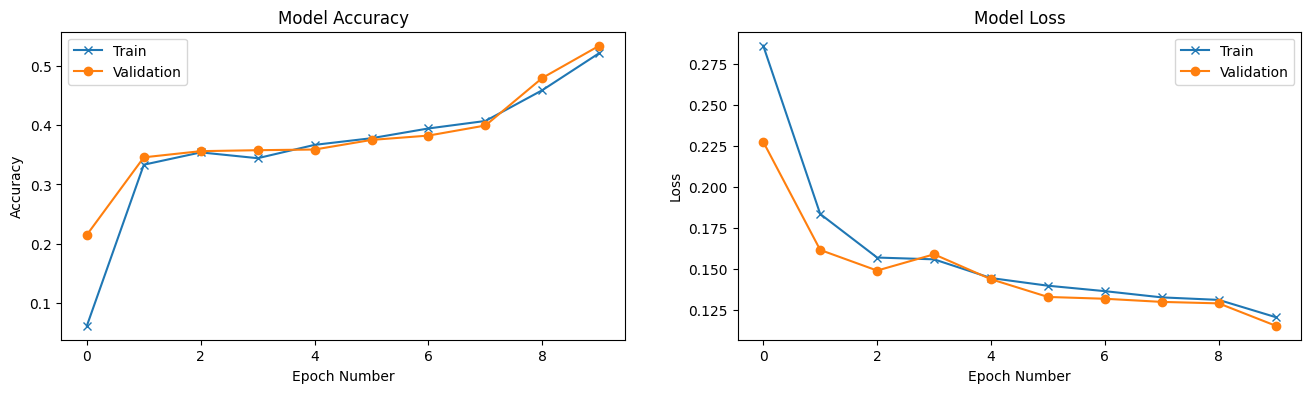

In [51]:
# Plot accuracy and loss over epochs
fig = plt.figure(figsize=(16, 4))

# Plot accuracy
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_logs['acc'], '-x', label='Train')
ax.plot(val_logs['acc'], '-o', label='Validation')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Accuracy')
ax.legend()

# Plot loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(train_logs['loss'], '-x', label='Train')
ax.plot(val_logs['loss'], '-o', label='Validation')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

### Visualising the Model's Output

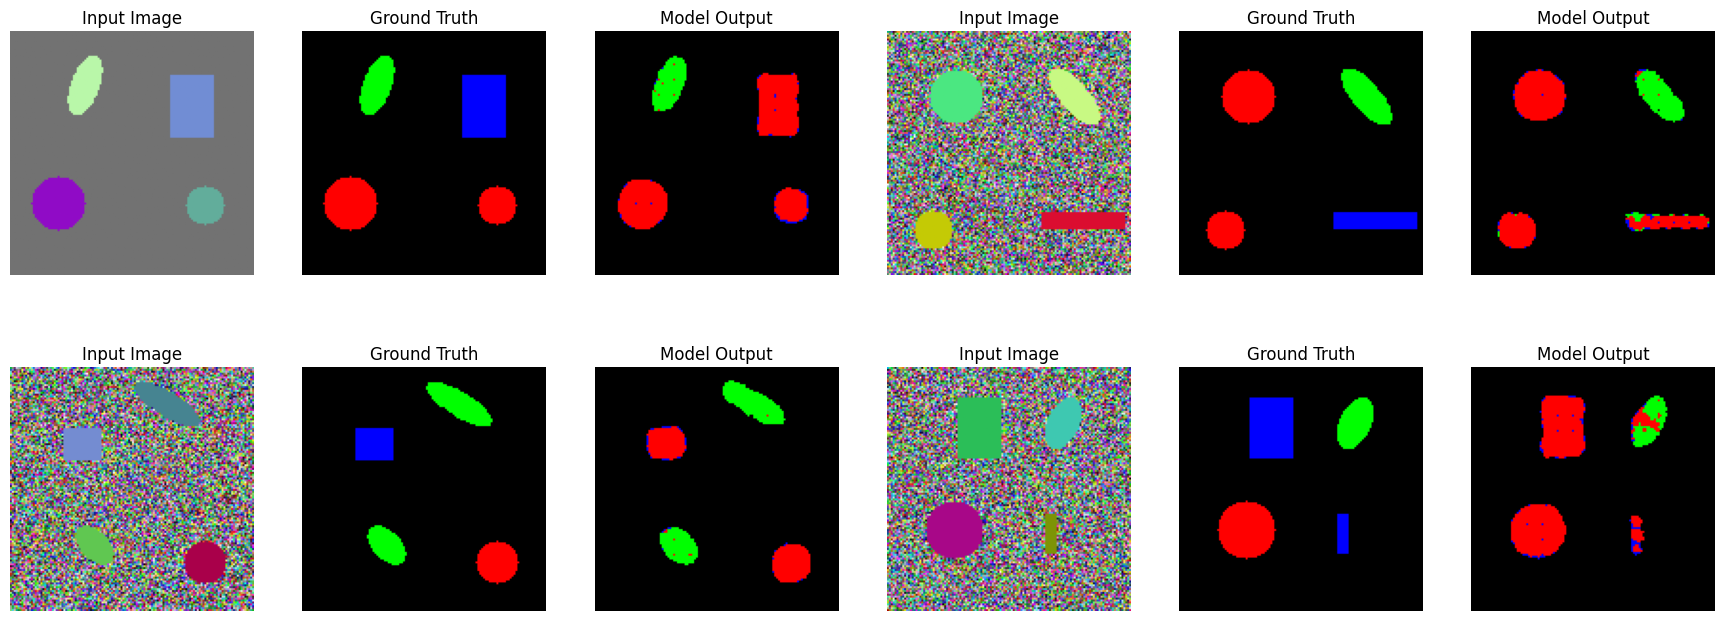

In [52]:
visualise_batch_output(val_loader)

## 6. Exercises

In this notebook, we built a simple semantic segmentation network that predicts the category label of each pixel. Here are some exercises to help you explore and enhance your understanding of the model and its components:

1. **Increase the complexity of your dataset by including additional geometrical shapes**  
   Currently, your dataset consists of a limited set of geometrical shapes. You can increase the complexity by adding other shapes like stars, or irregular polygons. You can also set `is_filled` to `False`. How does the model perform with a more challenging dataset? Does the network require more training or different architectural modifications to handle the added complexity?

2. **The accuracy for the experiment with background noise is not as high. How can you obtain higher accuracy?**  
   In the experiment where the background contains noise, the model's accuracy might be lower. What changes can you make to improve accuracy?

3. **Ignore background in loss function:**  
   Modify the loss function to exclude background pixels from the computation of the loss. This means that only the foreground pixels will contribute to the loss. How does excluding the background affect the performance of the model, especially with noisy backgrounds? Experiment with different loss functions and assess their impact on accuracy.

4. **Weighting Pixels:**  
   Instead of ignoring background pixels entirely, you can assign different weights to pixels based on their type. For example, foreground pixels could have a higher weight than background pixels. Modify the loss function to apply these weights. How does this affect the model's performance? Does it help the network focus more on the foreground objects during training?